# Opdracht classificatie 1 - logistic regression

Logistische regressie is een bijzonder populaire classificatietechniek. Enerzijds door zijn eenvoud en relatief lage eisen die het stelt in termen van rekenkracht. In veel gevallen is de performantie qua accuracy vergelijkbaar (en soms beter) dan gecompliceerdere algoritmes zoals de support vector machines.
Daarnaast heeft logistische regressie het voordeel dat het getrainde model een voorspelling doet in termen van de kans dat de input tot een bepaalde klasse behoort. Uit deze kans kan je afleiden hoe overtuigd het model is van de gemaakte voorspelling.

Het is de bedoeling om via enkele classificatieopdrachten inzicht te verkrijgen in:
- Correct trainen en het uitvoeren van hyperparameter tuning bij logistische regressie.
- Classificaties kunnen uitvoeren via logistische regressie.
- Feature engineering uitvoeren.
- Interpreteren van de verschillende performance metrics: accuracy, recall, precision, f1-score, ROC.
- Kunnen omgaan met niet-gebalanceerde data en het kunnen regelen tussen het aantal false positives en false negatives. 
- Weten wanneer je te maken hebt met overfitting en underfitting en de juiste bijstellingen kunnen doen.


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns

## Opdracht 1: Classificatie van wijn

Het doel van deze classificatie is te kunnen achterhalen op basis van chemische parameters van welke wijnboer (cultivar) een wijn afkomstig is.

Gebruik hiervoor de dataset *wine_data.csv*. De features bevinden zich in de eerste kolommen van de dataset. De targets/outputs zijn in de laatste kolom te vinden.

### Inlezen van de dataset en vooranalyse

In [2]:
# inlezen van de data
dataset = pd.read_csv('wine_data.csv')
dataset.head(10)


,inputs Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,flavanoids,NonflavanoidsPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline,Cultivar
0,12.08,1.33,2.30,23.6,70,2.20,1.59,0.42,1.38,1.74,1.07,3.21,625,1
1,12.08,1.13,2.51,24.0,78,2.00,1.58,0.40,1.40,2.20,1.31,2.72,630,1
2,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510,1
3,13.11,1.01,1.70,15.0,78,2.98,3.18,0.26,2.28,5.30,1.12,3.18,502,1
4,12.04,4.30,2.38,22.0,80,2.10,1.75,0.42,1.35,2.60,0.79,2.57,580,1
5,12.25,1.73,2.12,19.0,80,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510,1
6,12.69,1.53,2.26,20.7,80,1.38,1.46,0.58,1.62,3.05,0.96,2.06,495,1
7,12.77,3.43,1.98,16.0,80,1.63,1.25,0.43,0.83,3.40,0.70,2.12,372,1
8,13.88,5.04,2.23,20.0,80,0.98,0.34,0.40,0.68,4.90,0.58,1.33,415,2
9,12.08,1.83,2.32,18.5,81,1.60,1.50,0.52,1.64,2.40,1.08,2.27,480,1


In [3]:
dataset.shape

(178, 14)

Bepaal het aantal klasses. Met andere woorden, hoeveel verschillende wijnboeren zijn er? Is de dataset gebalanceerd? Een gebalanceere dataset is een dataset waar de verschillende klasses gelijkmatig voorkomen. Bij niet-gebalanceerde data kan het classificatiemodel een voorkeur krijgen voor de meerderheidsklasse.

In [4]:
# aantal klasses en gebalanceerdheid controleren
klasses = dataset.Cultivar.unique()
print(klasses)
len(klasses)

[1 2 0]


3

In [5]:
g = dataset.groupby('Cultivar').count()
print(g)

          inputs Alcohol  MalicAcid  Ash  AlcalinityOfAsh  Magnesium  \
Cultivar                                                               
0                     59         59   59               59         59   
1                     71         71   71               71         71   
2                     48         48   48               48         48   

          TotalPhenols  flavanoids  NonflavanoidsPhenols  Proanthocyanins  \
Cultivar                                                                    
0                   59          59                    59               59   
1                   71          71                    71               71   
2                   48          48                    48               48   

          ColorIntensity  Hue  OD280/OD315  Proline  
Cultivar                                             
0                     59   59           59       59  
1                     71   71           71       71  
2                     48   48        

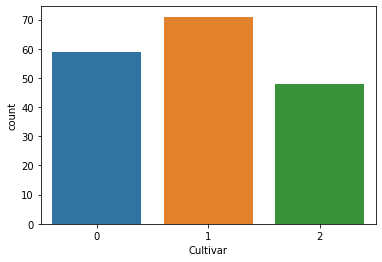

In [6]:
sns.countplot(x='Cultivar', data=dataset)

Bepaal de statistische kerngetallen van de verschillende features en targets. Gebruik hiervoor de *describe* functie (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html). Gebruik de resultaten om na te gaan of er mogelijks ontbrekende waarden, uitschieters of onrealistische waarden zijn.

In [7]:
# statistische vooranalyse
dataset.describe()

,inputs Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,flavanoids,NonflavanoidsPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline,Cultivar
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   inputs Alcohol        178 non-null    float64
 1   MalicAcid             178 non-null    float64
 2   Ash                   178 non-null    float64
 3   AlcalinityOfAsh       178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   TotalPhenols          178 non-null    float64
 6   flavanoids            178 non-null    float64
 7   NonflavanoidsPhenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   ColorIntensity        178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280/OD315           178 non-null    float64
 12  Proline               178 non-null    int64  
 13  Cultivar              178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


### Preprocessing en opsplitsen van de dataset

Splits de dataset in **features en targets**.

In [11]:
# opsplitsen in features en targets
y = dataset['Cultivar'].values
X = dataset.drop(['Cultivar'], axis=1).values

print(y.shape, X.shape)

(178,) (178, 13)


Creëer een **trainingset en een testset**. Zorg dat je 70 wijnen in de test set zitten hebt. Gebruik hiervoor train_test_split functie. Meer info is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [12]:
# aanmaken van een training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=70, random_state=120)

**Normaliseer de dataset**. Zorg er dus voor dat de features op een gelijke schaalverdeling staan. Voor het normaliseren kan gebruik gemaakt worden van de *preprocessing.StandardScaler()*. Meer info over het gebruik ervan is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [13]:
# normaliseren
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) op de training data. 
Kies C=1 als startwaarde. 

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen?

Probeer de performantie van het model te verhogen door het uitvoeren van hyperparameter tuning. Mogelijke hyperparameters zijn:
- Aanpassen van de waarde van C 
- Kiezen van een andere solver
- Regularisatie (penalty) toepassen via L1 of L2 
- Toevoegen van extra (polynomial) features 
- Indien je te maken hebt met niet-gebalanceerde data, dan kan je de class_weigt='balanced' parameter meegeven. Verklaar het effect ervan op de accuracy, recall, precision en de f1-score.


Schrijf de conclusies neer. 



In [14]:
# trainen van het model en hyperparameter tuning +  conclusies
logreg = linear_model.LogisticRegression(C=0.44, solver='liblinear')
model = logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))
print('\n')
print(accuracy_score(y_test, y_pred))

[[22  0  0]
 [ 0 29  1]
 [ 0  0 18]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      0.97      0.98        30
           2       0.95      1.00      0.97        18

    accuracy                           0.99        70
   macro avg       0.98      0.99      0.99        70
weighted avg       0.99      0.99      0.99        70



0.9857142857142858


Text(0, 0.5, 'Accuracy')

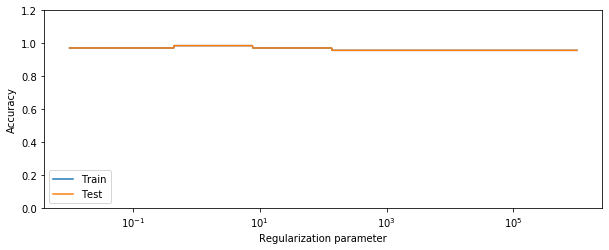

In [15]:
train_acc = []
test_acc = []


cs = np.logspace(-2, 6, 1000)

for c in cs:
    logreg = linear_model.LogisticRegression(C=c, solver='liblinear')
    logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred))
    train_acc.append(accuracy_score(y_test, y_pred))

# Plot r2
f, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.semilogx(cs, train_acc, label='Train')
plt.semilogx(cs, test_acc, label='Test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')

In [16]:
max(test_acc)
cs[test_acc.index(max(test_acc))]

0.4463233926710395

### Voorspel aan de hand van het getrainde model

Voorspel van welke wijnboer een wijn afkomstig is met volgende samenstelling:

inputs Alcohol: 13.52 - 
MalicAcid: 2.05 - 
Ash: 2.20 - 
AlcalinityOfAsh: 17.3 - 
Magnesium: 120 - 
TotalPhenols: 2.60 - 
flavanoids: 3.52 - 
NonflavanoidsPhenols: 0.30 - 
Proanthocyanins: 2.28 - 
ColorIntensity: 7.80 - 
Hue: 0.77 - 
OD280/OD315: 2.90 - 
Proline: 862


Geef ook de overtuiging van het model weer dat de wijn van die bepaalde wijnboer afkomstig is.

In [17]:
# predictie
wine = [[13.52, 2.05, 2.20, 17.3, 120, 2.60, 3.52, 0.30, 2.28, 7.80, 0.77, 2.90, 862]]

# scaler
wine = scaler.transform(wine)
# predict 
pred = logreg.predict(wine)
print(pred)
#probs predict
classification = logreg.predict_proba(wine)
print(classification)

[0]
[[9.99966174e-01 1.22841766e-07 3.37033995e-05]]


Vraag de coëfficiënten van het model op via '.coef_'. Verklaar waarom het aantal coëfficiënten een veelvoud is van het aantal features. Welke features spelen een belangrijke rol om te bepalen of een wijn al dan niet van wijnboer 1 afkomstig is?

In [18]:
# coëfficiënten interpreteren 
model.coef_

array([[ 1.04467752,  0.16456627,  0.64505689, -0.90826653, -0.03911357,
         0.2924864 ,  0.50308355, -0.17845017, -0.14241879, -0.02204284,
         0.24082192,  0.62602893,  1.30750262],
       [-1.28055731, -0.69285711, -0.79797774,  0.56538891, -0.08171916,
         0.07130323,  0.23972581,  0.09713692,  0.32220602, -0.97949127,
         0.52100215,  0.02752276, -1.14285372],
       [ 0.38419114,  0.62315039,  0.23295089,  0.21338276,  0.03408266,
        -0.3640689 , -0.73692394,  0.10825322, -0.19605863,  1.02279427,
        -0.74641789, -0.64168372, -0.12533263]])

### Conclusie
Omdat er X aantal verschillende klasses zijn.  
Het alcohol percentage speelt een belangrijke rol in de klassificatie.

## Opdracht 2: Diabetes

Het bestand *diabetes.csv* bevat medische gegevens van meer dan 300 personen waarbij telkens geweten is of de persoon al dan niet diabetes heeft.
Train nu een logic regression model dat op basis van de features een zo goed mogelijke predictie kan doen of iemand al dan niet diabetes heeft.

### Inlezen van de dataset en vooranalyse

In [3]:
# inlezen van de dataset
dataset = pd.read_csv('diabetes.csv')
dataset.shape

(768, 9)

Controleer of de dataset inconsistenties of foute waarden bevat. Gebruik listwise deletion. Dit betekent dat je alle gegevens van een persoon uit de dataset verwijdert van zodra er 1 feature foutief is of ontbreekt.

In [4]:
# inconsistenties opsporen
dataset[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']] = dataset[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']].replace(0, np.NaN)

In [5]:
dataset.dropna(inplace=True)
dataset.shape

(392, 9)

Bepaal de verdeling van het aantal personen met diabetes ten opzichte van het aantal personen zonder. Is de dataset gebalanceerd?

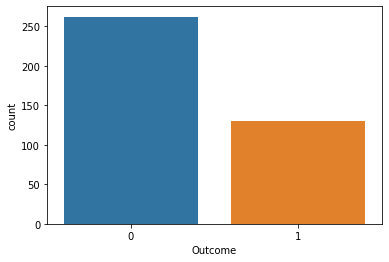

In [6]:
# gebalanceerdheid controleren
sns.countplot(x='Outcome', data=dataset)

In [ ]:
# De dataset is niet gebalanceerd, er zijn veer meer gevallen waarbij er geen diabetes is vast gesteld.

Bepaal de statistische kerngetallen van de verschillende features en target. Gebruik hiervoor de *describe* functie.

In [8]:
#statistische kerngetallen
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


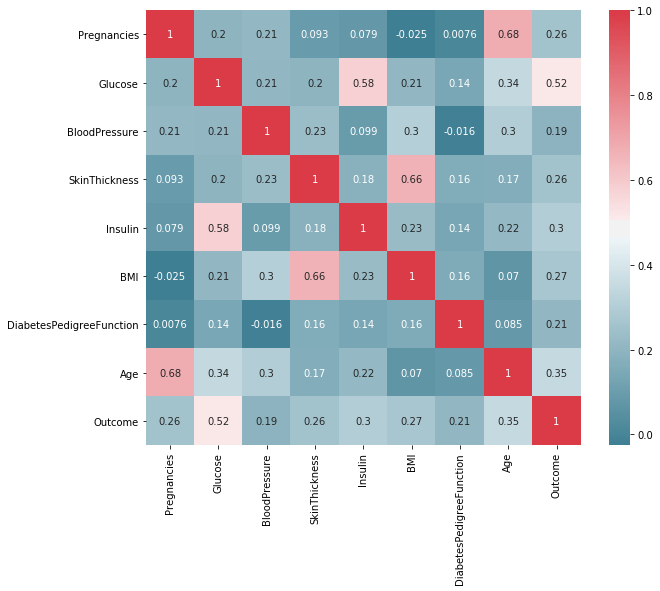

In [10]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, square=True, 
            mask=np.zeros_like(dataset.corr(), dtype=np.bool), ax=ax,
           cmap=sns.diverging_palette(220, 10, as_cmap=True))

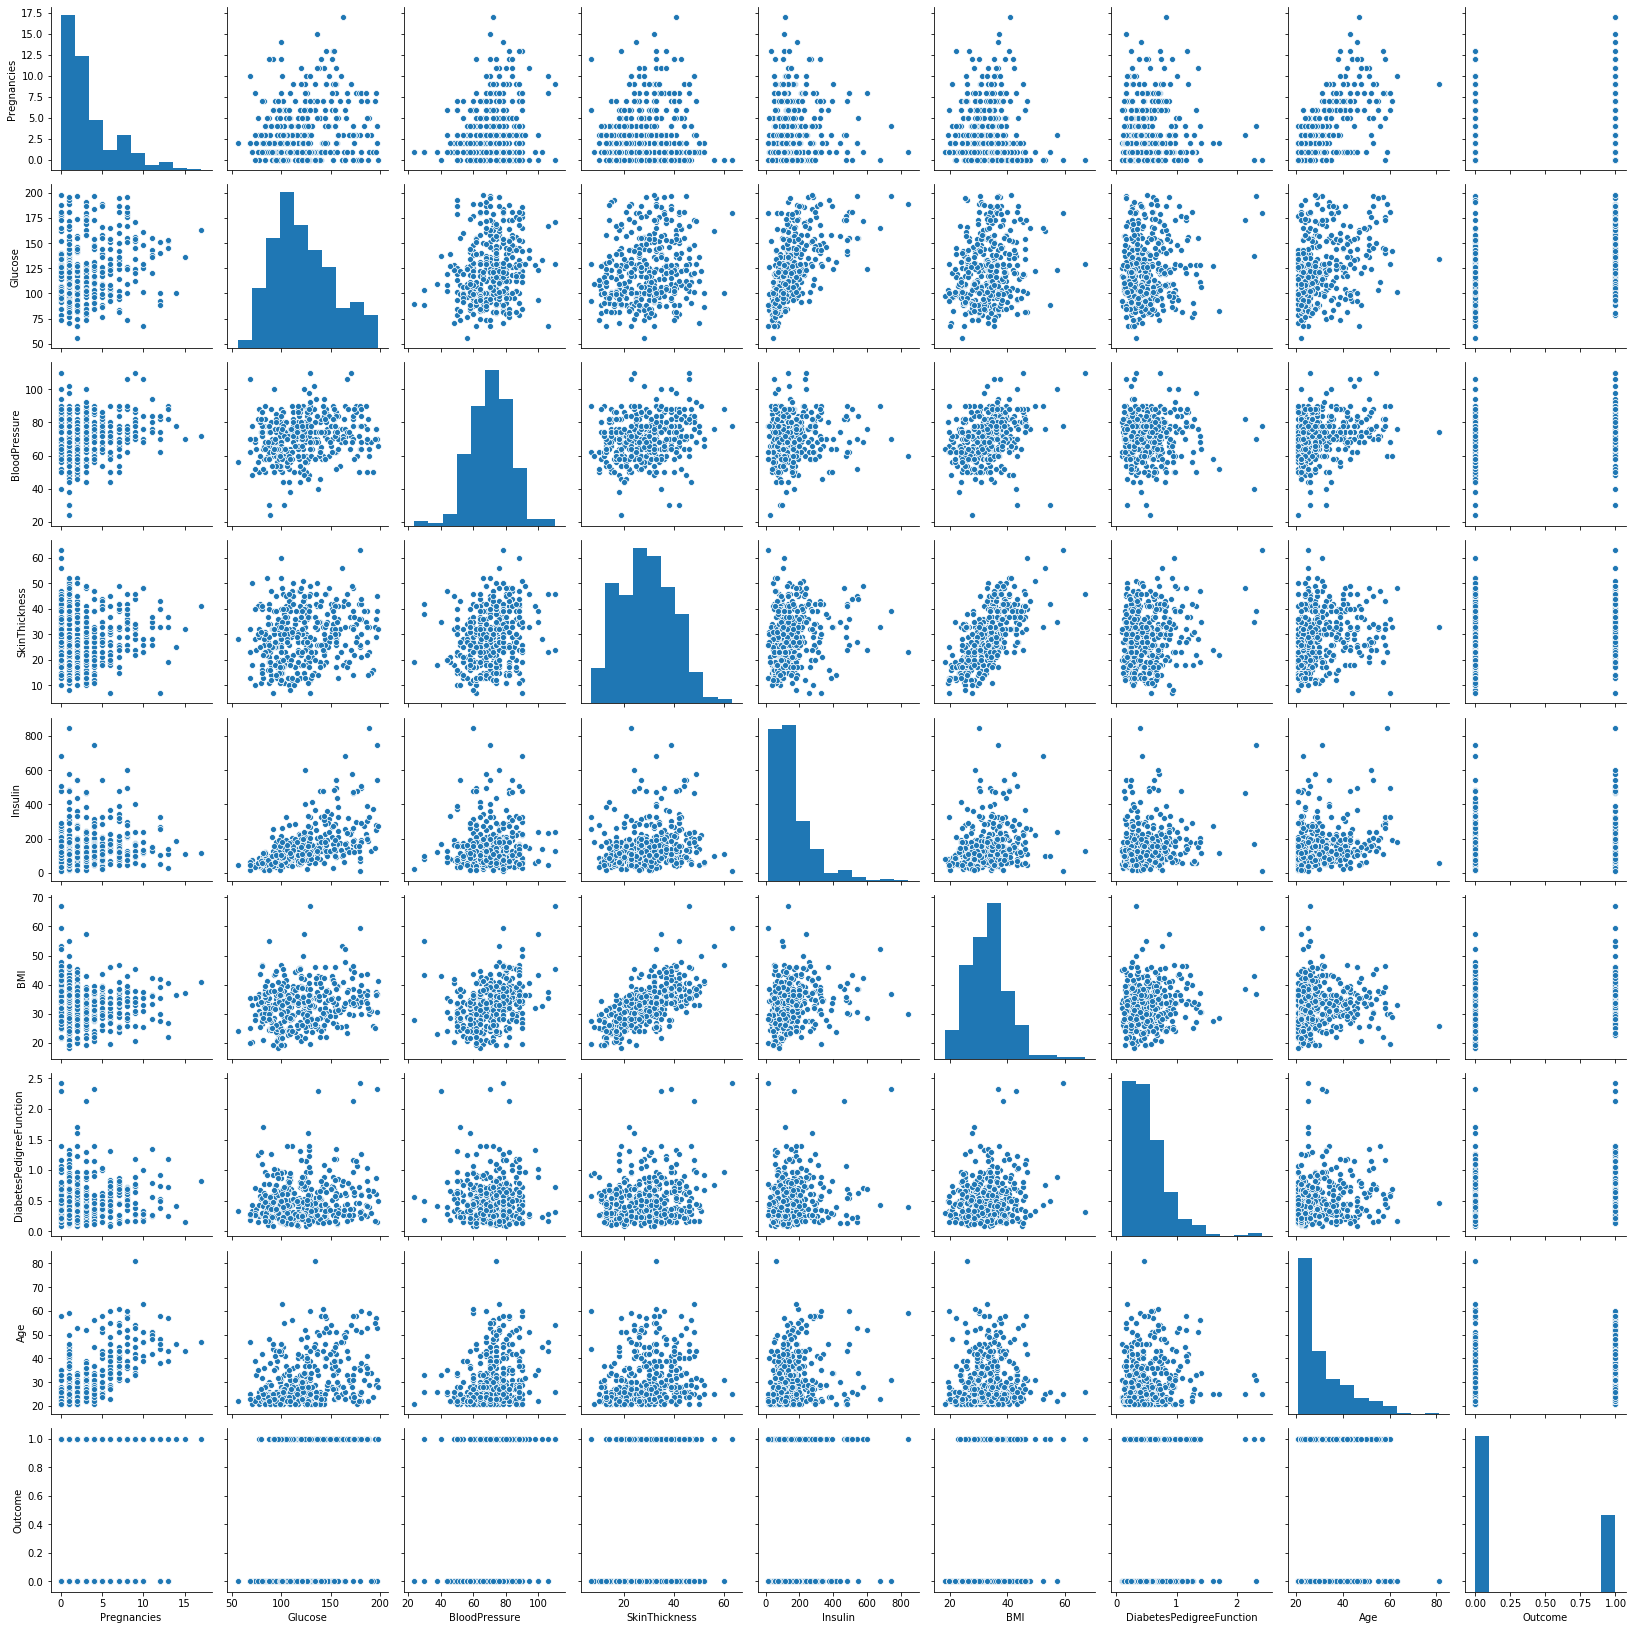

In [11]:
sns.pairplot(dataset)

### Preprocessing en opsplitsen van de dataset

Splits de dataset in **features en targets**.

In [7]:
# Opsplitsen in features en targets
y = dataset.Outcome.values
X = dataset.drop(['Outcome'], axis=1).values

Creëer een **trainingset en een testset**. Zorg dat er 100 patiënten in de testset steken. 

In [8]:
# training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=30)

**Normaliseer de dataset**. Zorg er dus voor dat de features op een gelijke schaalverdeling staan. Voor het normaliseren kan gebruik gemaakt worden van de *preprocessing.StandardScaler()*. Meer info over het gebruik ervan is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [9]:
# normalisatie
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier op de training data. Kies C=1 als startwaarde. Mocht de dataset niet gebalanceerd zijn (de ene klasse komt frequenter voor dan de andere klasse) dan kan je bij de creatie van het logistic regression model de parameter class_weight='balanced' meegeven. Meer info: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen? Probeer ook verschillende solvers uit. Bepaal ook telkens de ROC en formuleer conclusies.

Probeer de performantie van de classifier te verhogen door de parameter C te veranderen.

In [25]:
# hyperparameter tuning
log_reg = linear_model.LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))
print('\n')
print(accuracy_score(y_test, y_pred))

[[55 17]
 [ 8 20]]


              precision    recall  f1-score   support

           0       0.87      0.76      0.81        72
           1       0.54      0.71      0.62        28

    accuracy                           0.75       100
   macro avg       0.71      0.74      0.72       100
weighted avg       0.78      0.75      0.76       100



0.75


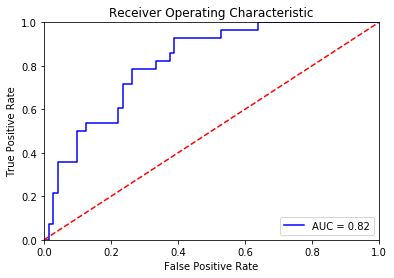

In [23]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = log_reg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

newton-cg acc: 0.79, auc: 0.82
lbfgs acc: 0.79, auc: 0.82
liblinear acc: 0.79, auc: 0.82
sag acc: 0.79, auc: 0.82
saga acc: 0.79, auc: 0.82


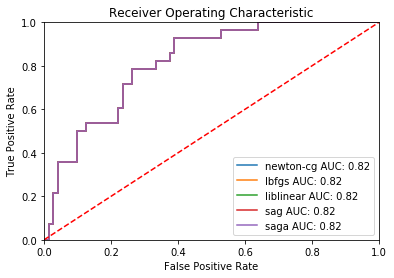

In [46]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
import sklearn.metrics as metrics

rocs = []
for solver in solvers:
    tmp_log_reg = linear_model.LogisticRegression(C=0.01, class_weight='balanced', solver=f'{solver}')
    tmp_log_reg.fit(X_train, y_train)
    
    y_pred_temp = tmp_log_reg.predict(X_test)
    probs = tmp_log_reg.predict_proba(X_test)
    preds = probs[:,1]
    
    tmp_acc = accuracy_score(y_test, y_pred)
    tmp_f1_score = metrics.f1_score(y_test, y_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    rocs.append([fpr, tpr, roc_auc, solver])
    
    print(f'{solver} acc: {tmp_acc}, auc: {roc_auc:.2f}')

plt.title('Receiver Operating Characteristic')
for roc in rocs:
    plt.plot(roc[0], roc[1], label=f'{roc[3]} AUC: {roc[2]:.2f}')
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0, 0.5, 'Accuracy')

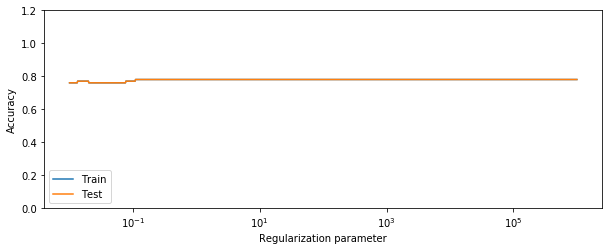

In [13]:
train_acc = []
test_acc = []


cs = np.logspace(-2, 6, 1000)

for c in cs:
    logreg = linear_model.LogisticRegression(C=c, solver='liblinear')
    logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred))
    train_acc.append(accuracy_score(y_test, y_pred))

# Plot r2
f, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.semilogx(cs, train_acc, label='Train')
plt.semilogx(cs, test_acc, label='Test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')

### Bevindingen
De accuracy lijkt met 75% vrij oke.  
We zien echter dat er een groot verschil is tussen de F1-scores. Dit komt waarschijnlijk door de ongebalanceerde data. 
De recall van beide klassen zijn ongeveer gelijk, wat wil zeggen dat ondanks de ongebalanceerde data, het model geen specifieke voorkeur heeft gekregen voor een klasse.  
Er is wel een groot verschil in precisie. Die is vrij laag bij klasse 1. Wat dan weer wel kan duiden op ongebalanceerde data.  
De verschillende solvers geven allemaal het zelfde resultaat voor een optimale "C" waarde.

### Feature engineering
Creeër hogere orde features door gebruik te maken van *preprocessing.PolynomialFeatures*. Meer info is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Deze functie zal automatische hogere orde features aanmaken door het combineren van de aanwezige features. Heb je bijvoorbeeld drie features, zijnde A, B en C dan worden bij de keuze van een derde orde PolynomialFeatures volgende nieuwe features bijgemaakt:
$A^3, B^3,C^3,A^2B,A^2C,AB^2, B^2C,...$

Experimenteer met verschillende ordes en gebruik de regularisatieparameter C om de performantie te verhogen. Voor indien nodig ook regularisatie uit via een L1 of L2 penalty.

**Opgepast**: het kiezen van een te hoge orde zorgt voor een exponentiële toename aan features waardoor de logistic regression classifier niet meer binnen aanvaardbare tijd getraind kan worden. Advies is om niet hoger te gaan dan 4de orde.

0.610640754223204

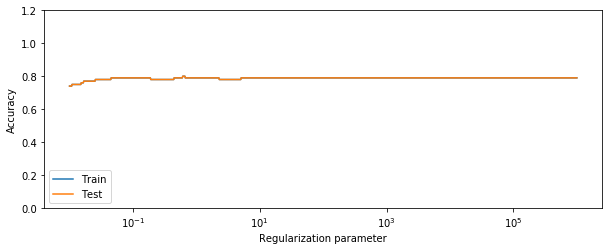

In [42]:
train_acc = []
test_acc = []


cs = np.logspace(-2, 6, 1000)

graad = 2
poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

for c in cs:
    logreg = linear_model.LogisticRegression(C=c, class_weight='balanced', solver='liblinear')
    logreg.fit(X_train_poly,y_train)
    y_pred = logreg.predict(X_test_poly)
    test_acc.append(accuracy_score(y_test, y_pred))
    train_acc.append(accuracy_score(y_test, y_pred))

# Plot r2
f, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.semilogx(cs, train_acc, label='Train')
plt.semilogx(cs, test_acc, label='Test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')

cs[test_acc.index(max(test_acc))]

In [41]:
lregmodel_poly = linear_model.LogisticRegression(C=0.610640754223204,solver='liblinear', class_weight='balanced')
lregmodel_poly.fit(X_train_poly,y_train)

y_pred = lregmodel_poly.predict(X_test_poly)

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))
print('\n')
print(accuracy_score(y_test, y_pred))

[[60 12]
 [ 8 20]]


              precision    recall  f1-score   support

           0       0.88      0.83      0.86        72
           1       0.62      0.71      0.67        28

    accuracy                           0.80       100
   macro avg       0.75      0.77      0.76       100
weighted avg       0.81      0.80      0.80       100



0.8


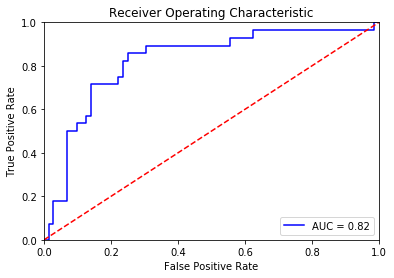

In [33]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = lregmodel_poly.predict_proba(X_test_poly)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

newton-cg acc: 0.79, auc: 0.83
lbfgs acc: 0.79, auc: 0.83
liblinear acc: 0.79, auc: 0.83
sag acc: 0.79, auc: 0.83
saga acc: 0.79, auc: 0.83


/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


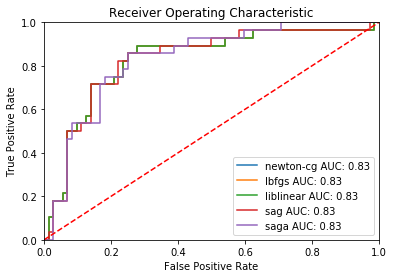

In [43]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
import sklearn.metrics as metrics

rocs = []
for solver in solvers:
    tmp_log_reg = linear_model.LogisticRegression(C=1, class_weight='balanced', solver=f'{solver}')
    tmp_log_reg.fit(X_train_poly, y_train)
    
    y_pred_temp = tmp_log_reg.predict(X_test_poly)
    probs = tmp_log_reg.predict_proba(X_test_poly)
    preds = probs[:,1]
    
    tmp_acc = accuracy_score(y_test, y_pred)
    tmp_f1_score = metrics.f1_score(y_test, y_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    rocs.append([fpr, tpr, roc_auc, solver])
    
    print(f'{solver} acc: {tmp_acc}, auc: {roc_auc:.2f}')

plt.title('Receiver Operating Characteristic')
for roc in rocs:
    plt.plot(roc[0], roc[1], label=f'{roc[3]} AUC: {roc[2]:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Wat zijn de bevindingen? Formuleer een conclusie. Bespreek hierin de performantie van de getrainde modellen. Wat is de invloed van de parameter C en van het aantal features? Heb je te maken gehad met underfitting en overfitting en hoe heb je dit bepaald? Welke accuracy werd bekomen en hoe zit het met de Recall en Precision? Is de grootte van de trainingset voldoende?

### Antwoord
Een model met polynomal features van de 2de graad haalt de beste accuracy van **80%**. Verschillende solvers toepassen maakt geen verschil op het resultaat, alle **AUC** waarden liggen gelijk.  
De F1 scores zijn voor beide klasses met **5%** gestegen. Bij klasse 0 is ook de recall met **7%** gestegen.  
De precission is voor beide klasses gestegen, de sterkste stijging is voor klasse 1 met **8%**.
Ondanks de stijging van precision ligt deze voor klasse 1 nog altijd vrij laag met slechts **62%**. Dit komt waarschijnlijk door de ongebalanceerde dataset.

### Voorspel aan de hand van het getrainde model

Voorspel of iemand met onderstaande medische parameters als dan niet diabetes heeft. Geef ook de zekerheid van het model weer (kansen dat de patiënt tot een bepaalde klasse behoort).

Pregnancies: 2 -
Glucose: 132 -
BloodPressure: 74 - 
SkinThickness: 20 - 
Insulin: 21 - 
BMI: 24.3 - 
DiabetesPedigreeFunction: 128 - 
Age: 37

In [53]:
# voorspelling
test = [[2, 132, 74, 20, 21, 24.3, 128, 37]]
test = scaler.transform(test)
poly = PolynomialFeatures(graad)
poly.fit(test)
test_poly = poly.transform(test)

prediction = lregmodel_poly.predict_proba(test_poly)[0]
pred = lregmodel_poly.predict(test_poly)

print('Kans op op diabetis: ', prediction[1] * 100, '%')
print('Kans op geen diabetis: ', prediction[0] * 100, '%')

Kans op op diabetis:  100.0 %
Kans op geen diabetis:  0.0 %


Standaard zal het model een sample toewijzen aan klasse 1 van zodra de probiliteit boven de threshold van 50% uisteekt. 
Men wil echter de kans op false negatives drastisch verminderen door het aanpassen van de threshold. Welke threshold moet men instellen om ervoor te zorgen dat het model op de test set geen false negatives meer voorspelt en toch nog een zo hoog mogelijke accuraatheid heeft?
Stel het aantal false negatives in functie van de threshold grafisch voor. Bespreek de resultaten.

0.5782802243649917


(0, 1)

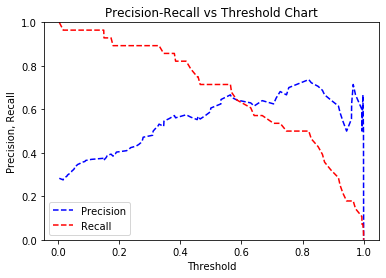

In [56]:
# reduceren van het aantal false negatives door de threshold aan te passen

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, preds) 
pr_auc = metrics.auc(recall, precision)
print(pr_auc)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


### Resultaat
Om het aantal false negatives naar beneden te halen kan je de treshhold instellen op **0.57**.
Je kan dit doen door de kansverdeling op te vragen ipv het resultaat en op deze kansverdeling `predict_prob()` zelf het treshold toe te passen.

## Opdracht 3. Human resources

Een groot bedrijf probeert te voorspellen of een werknemer binnenkort al dan niet het bedrijf zal verlaten en hoopt zo tijdig te kunnen ingrijpen.
Gebruik logistische regressie op de dataset 'Human_Resources.csv' om een zo accuraat mogelijk model te trainen. 
Tevens wil het bedrijf vooral false negatives vermijden.
Welke zijn de top 3 features die het sterkst bepalen of een werknemer het bedrijf zal verlaten?

De dataset bestaat uit de volgende features:

- satisfaction_level: mate van voldoening op het werk.
- last_evaluationTime: aantal jaar sinds de laatste evaluatie.
- number_project: het aantal projecten die de werknemer op het bedrijf heeft afgewerkt.
- average_montly_hours: het aantal uur die de werknemer gemiddeld per maand aanwezig is op de werkplaats.
- time_spend_company: het aantal jaar in dienst van het bedrijf.
- work_accident: of de werknemer al een werkongeval heeft gehad.
- promotion_last_5years: of de werknemer al dan niet een promotie heeft gehad de afgelopen 5 jaar.
- department: het departement waar de werknemer voor werkt.
- salary: relatief loon (low, medium, high).

De te voorspellen target = left: of de werknemer het bedrijf al dan niet heeft verlaten (0 of 1)

Gebruik one-hot encoding om categorische features om te zetten naar one-hot features.

In [279]:
dataset = pd.read_csv('Human_Resources.csv')
print('Dimensie van de dataset:',dataset.shape)
dataset.head()

Dimensie van de dataset: (14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [69]:
# statistische kerngetallen
dataset.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


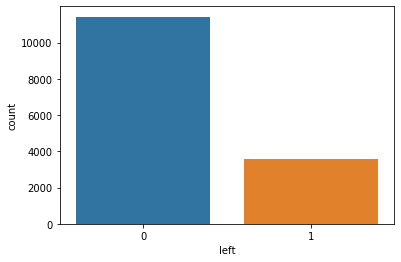

In [76]:
# Bekijk verdeling van de labels
sns.countplot(x='left', data=dataset)

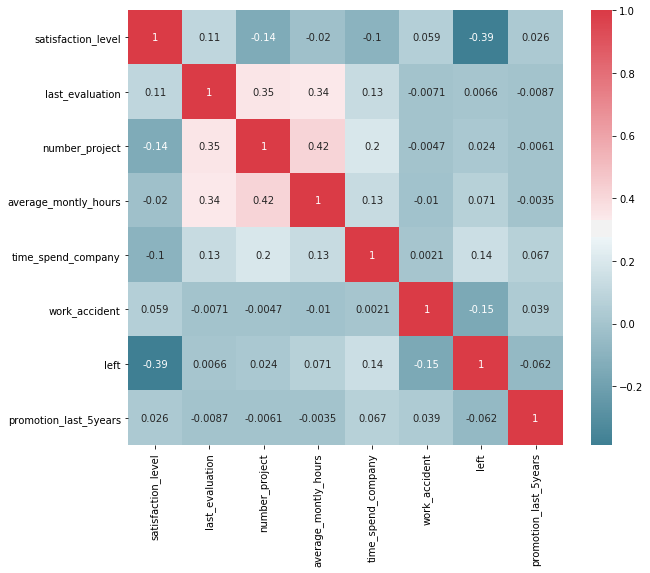

In [252]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, square=True, 
            mask=np.zeros_like(dataset.corr(), dtype=np.bool), ax=ax,
           cmap=sns.diverging_palette(220, 10, as_cmap=True))

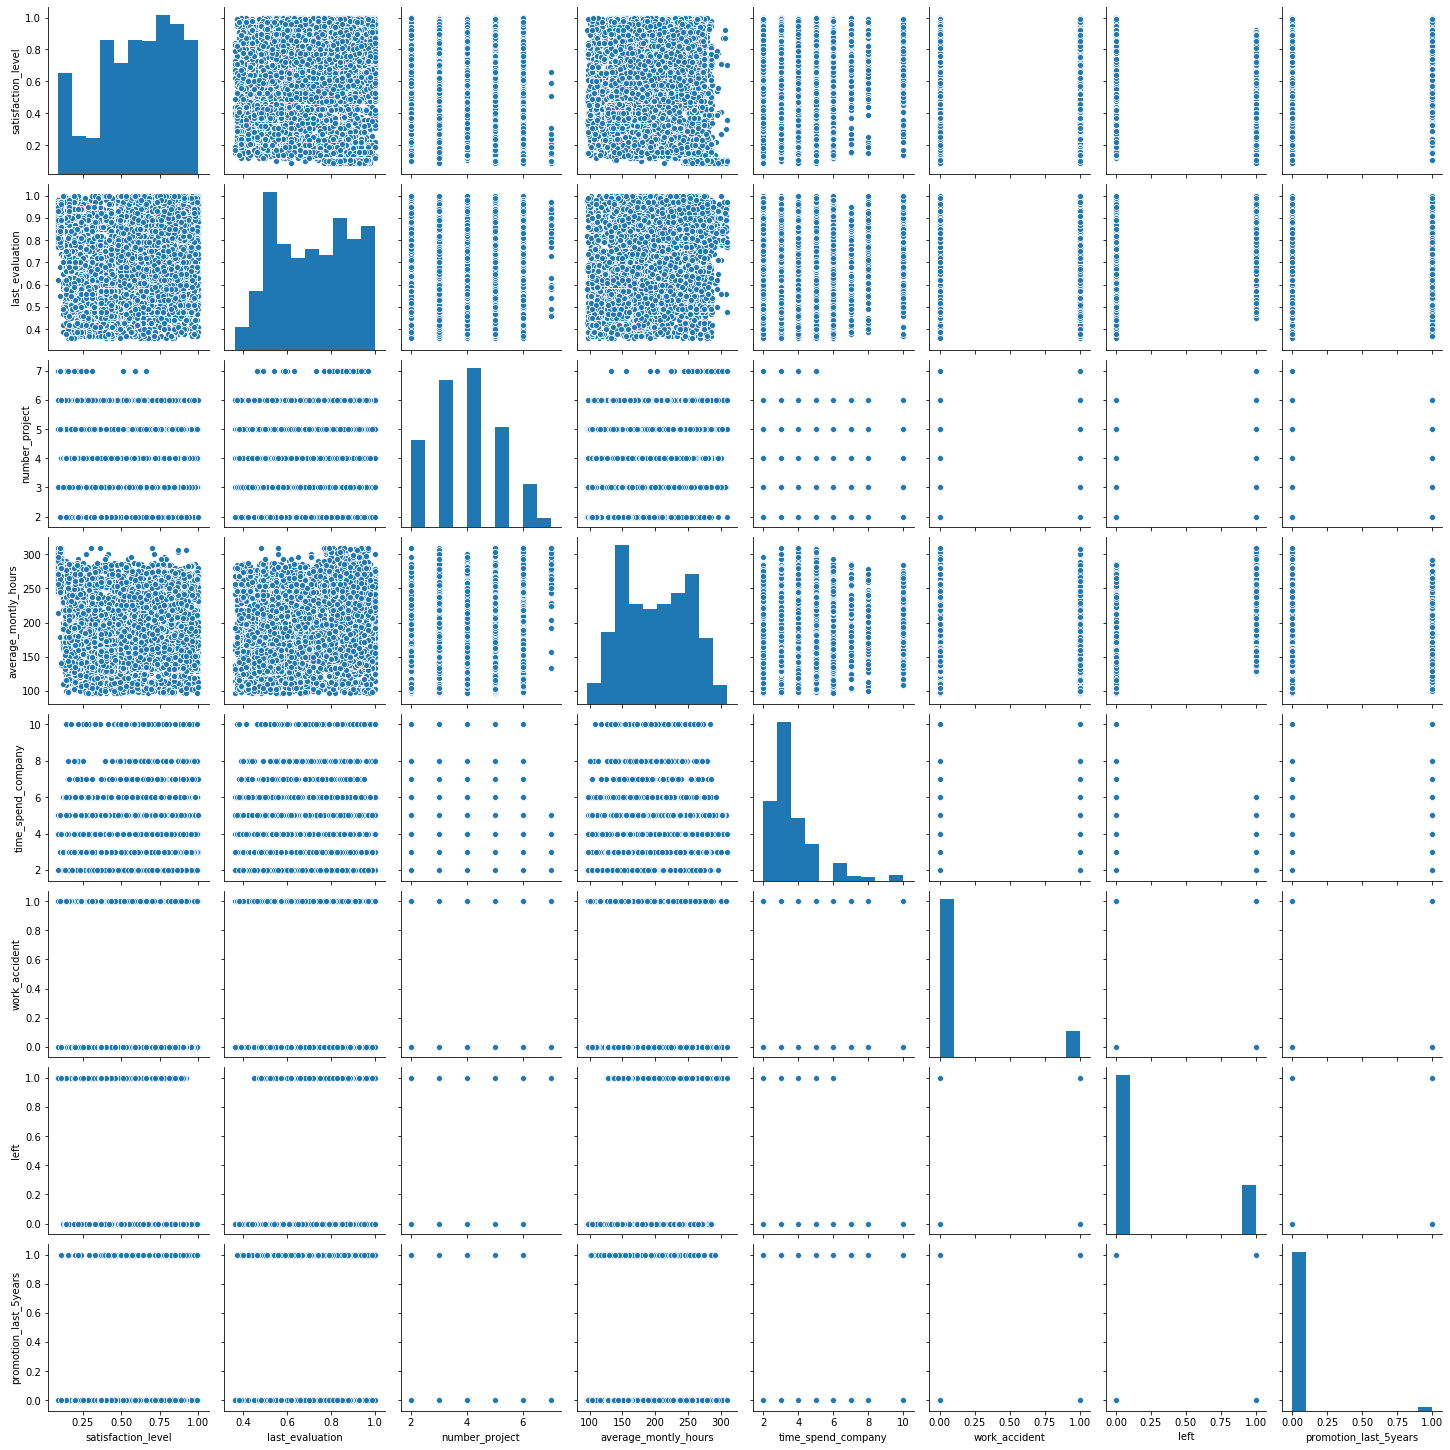

In [236]:
sns.pairplot(dataset)

### Feature analyse
De voornaamste features zijn:
* Satisfaction level
* Work accident
* Promotion in the last 5 years

In [265]:
# One-Hot encoding toepassen
dataset = pd.get_dummies(dataset)
dataset.head()
print('Shape after one-hot encoding:', dataset.shape)

Shape after one-hot encoding: (14999, 21)


In [266]:
y = dataset['left']
X = dataset.drop(['left'], axis=1)

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

In [268]:
log_reg = LogisticRegression(C=0.014694918006248165, class_weight='balanced', solver='liblinear').fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [269]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[2485  867]
 [ 192  956]]
              precision    recall  f1-score   support

           0       0.93      0.74      0.82      3352
           1       0.52      0.83      0.64      1148

    accuracy                           0.76      4500
   macro avg       0.73      0.79      0.73      4500
weighted avg       0.83      0.76      0.78      4500

0.7646666666666667


In [259]:
for i, feature in enumerate(X):
    print(f'Feature {feature} -> {log_reg.coef_[0][i]}')

Feature satisfaction_level -> -1.0131451376576641
Feature last_evaluation -> 0.174866131042645
Feature number_project -> -0.43601627226317347
Feature average_montly_hours -> 0.20837340860646225
Feature time_spend_company -> 0.6068936649144555
Feature work_accident -> -0.4566074451981201
Feature promotion_last_5years -> -0.14716407769676398
Feature department_IT -> -0.019673114742797704
Feature department_RandD -> -0.1144734941453309
Feature department_accounting -> 0.03477323463912938
Feature department_hr -> 0.06487711582447961
Feature department_management -> -0.10437855004141797
Feature department_marketing -> -0.004744722669080548
Feature department_product_mng -> -0.03411668653708404
Feature department_sales -> 0.023340206974505822
Feature department_support -> 0.03836052339163726
Feature department_technical -> 0.040977881558372224
Feature salary_high -> -0.409276078340657
Feature salary_low -> 0.23848363917277163
Feature salary_medium -> -0.010994903472909384


(0, 1)

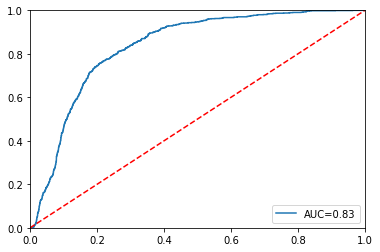

In [260]:
probs = log_reg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.ylim([0, 1])
plt.xlim([0, 1])

0.7595555555555555 0.1911090621689138


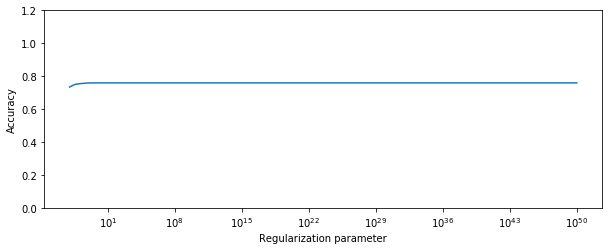

In [261]:
cs = np.logspace(-3, 50, 1000)
acc_points = []
for c in cs:
    log_reg = LogisticRegression(C=c, class_weight='balanced', solver='liblinear').fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    acc_points.append(accuracy_score(y_pred, y_test))

f, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.semilogx(cs, acc_points)
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')

print(max(acc_points), cs[acc_points.index(max(acc_points))])

newton-cg acc: 0.7595555555555555, auc: 0.83
lbfgs acc: 0.7595555555555555, auc: 0.83
liblinear acc: 0.7595555555555555, auc: 0.83


/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


sag acc: 0.7595555555555555, auc: 0.82
saga acc: 0.7595555555555555, auc: 0.81


/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


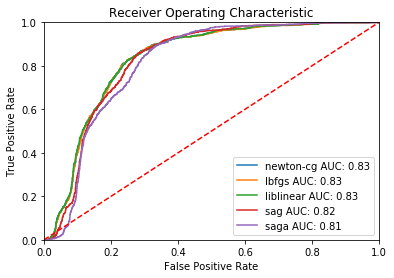

In [161]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
import sklearn.metrics as metrics

rocs = []
for solver in solvers:
    tmp_log_reg = linear_model.LogisticRegression(C=0.012067926406393288, class_weight='balanced', solver=f'{solver}')
    tmp_log_reg.fit(X_train, y_train)
    
    y_pred_temp = tmp_log_reg.predict(X_test)
    probs = tmp_log_reg.predict_proba(X_test)
    preds = probs[:,1]
    
    tmp_acc = accuracy_score(y_test, y_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    rocs.append([fpr, tpr, roc_auc, solver])
    
    print(f'{solver} acc: {tmp_acc}, auc: {roc_auc:.2f}')

plt.title('Receiver Operating Characteristic')
for roc in rocs:
    plt.plot(roc[0], roc[1], label=f'{roc[3]} AUC: {roc[2]:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Bevinding
Het gebruik van verschillende solvers met een optimale **c** heeft geen invloed op de accuracy.  
De **recall** van klasse 1 is vrij laag met **52%**, dit wil zeggen dat het model moeite heeft om klasses van klasse 1 correct te labelen. Terwijl de **recall** van klasse 0 vrij hoog ligt met **93%**. Dit heeft waarschijnlijk te maken met de niet gebalanceerde dataset.
De **precision** doet het voor beide klasses een stuk beter met **75%** en **80%**

In [270]:
graad = 2
poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

/home/florian/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


newton-cg acc: 0.9355555555555556, auc: 0.96


/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


lbfgs acc: 0.9355555555555556, auc: 0.83
liblinear acc: 0.9355555555555556, auc: 0.91


/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


sag acc: 0.9355555555555556, auc: 0.74
saga acc: 0.9355555555555556, auc: 0.62


/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


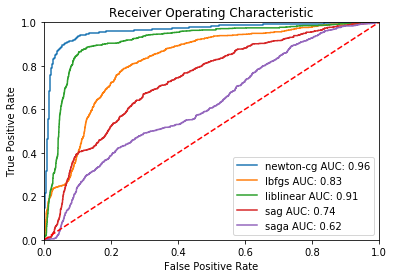

In [271]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
import sklearn.metrics as metrics

rocs = []
for solver in solvers:
    tmp_log_reg = LogisticRegression(C=0.1, solver=f'{solver}').fit(X_train_poly, y_train)
    poly_y_pred = poly_reg.predict(X_test_poly)
    
    probs = tmp_log_reg.predict_proba(X_test_poly)
    preds = probs[:,1]
    
    tmp_acc = accuracy_score(y_test, poly_y_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    rocs.append([fpr, tpr, roc_auc, solver])
    
    print(f'{solver} acc: {tmp_acc}, auc: {roc_auc:.2f}')

plt.title('Receiver Operating Characteristic')
for roc in rocs:
    plt.plot(roc[0], roc[1], label=f'{roc[3]} AUC: {roc[2]:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [272]:
poly_reg = LogisticRegression(C=0.1, solver='newton-cg').fit(X_train_poly, y_train)
poly_y_pred = poly_reg.predict(X_test_poly)

/home/florian/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


In [273]:
print(confusion_matrix(y_test, poly_y_pred))
print(classification_report(y_test, poly_y_pred))
print(accuracy_score(y_test, poly_y_pred))

[[3230  122]
 [ 168  980]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3352
           1       0.89      0.85      0.87      1148

    accuracy                           0.94      4500
   macro avg       0.92      0.91      0.91      4500
weighted avg       0.93      0.94      0.94      4500

0.9355555555555556


### Finale bevindingen
Door verschillende solvers te gebruiken, kunnen we zien dat **newton-cg** ons het beste resultaat geeft.  
Met een gemiddelde accuracy van **94%** scoort dit model goed. De **recall** en de **precision** liggen ook zeer dicht bij elkaar, wat wil zeggen dat er amper nog een verschil te merken is tussen de niet gebalenceerde data

In [292]:
test = [[0.6, 1, 3.5, 250, 5, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 1, 0,0]]
test = poly.transform(test)
poly_reg.predict_proba(test)

array([[0.91419451, 0.08580549]])